<div align="left">
<img align="left" src="datasciencebowl.png" >
<div> <b> Kaggle </b></div>
<div> 2018 Data Science Bowl </div>
<div> Pedro D. Marrero Fernandez</div>
<div> https://www.kaggle.com/c/data-science-bowl-2018/discussion/47770 </div>
<div> :), :(, :/</div>
</div>

In [1]:
import os
import torch
import pandas as pd
from skimage import io, transform
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
import csv
from skimage import color
import scipy.misc

import torch
import torch.nn as nn
import torchvision.models as models
from torch.autograd import Variable
import torch.nn.functional as tfun
import cv2
import skfmm

from deep.datasets import imageutl as imutl
from deep.datasets import utility as utl
from deep.datasets import weightmaps 
from deep import netmodels as nnmodels
from deep import visualization as view
from deep import netutility as nutl

# Ignore warnings
import warnings
warnings.filterwarnings("ignore")

plt.ion()   # interactive mode

# PIPELINE TEST
# Load and Read image dataset

In [2]:

def imageshowlist(image_a, image_b, image_c ):    
    plt.figure( figsize=(16,16))
    plt.subplot(131)
    plt.imshow( image_a )
    plt.axis('off')
    plt.subplot(132)
    plt.imshow( image_b )
    plt.axis('off')
    plt.subplot(133)
    plt.imshow( image_c )
    plt.axis('off')
    plt.show()
    
def imageshow( image, title='image'):
    plt.figure( figsize=(8,8))
    plt.imshow( image )
    plt.axis('off')
    plt.show()
    
def showsegmentation(pred):
    plt.figure( figsize=(16,16) )
    plt.subplot(141)
    plt.imshow( image[:,:,0], cmap='gray' )
    plt.title('input')
    plt.subplot(142)
    plt.imshow( pred[:,:,0], cmap='gray' )
    plt.title('fog')
    plt.subplot(143)
    plt.imshow( pred[:,:,1], cmap='gray' )
    plt.title('bak')
    plt.subplot(144)
    plt.imshow( pred[:,:,2], cmap='gray' )
    plt.title('edg')
    
def summary(data):
    print(np.min(data), np.max(data), data.shape)
    
def normalize(data):
    tdata = data - np.min(data)
    tdata = tdata / np.max(data)
    return tdata

In [3]:
pathdataset = '../db'
namedataset = 'databoewl'
metadata = 'stage1_train_labels.csv'
pathname = os.path.join(pathdataset, namedataset);
pathmetadata = os.path.join(pathdataset, namedataset, metadata)

base_folder = pathname
sub_folder =  imutl.trainfile
id_file_name = metadata
folders_image='images'
folders_masks='masks'

dataloader = imutl.dsxbProvide.create(
    base_folder, 
    sub_folder, 
    id_file_name, 
    folders_image, 
    folders_masks
    )

print(len(dataloader))
print(':)!!!')

670
:)!!!


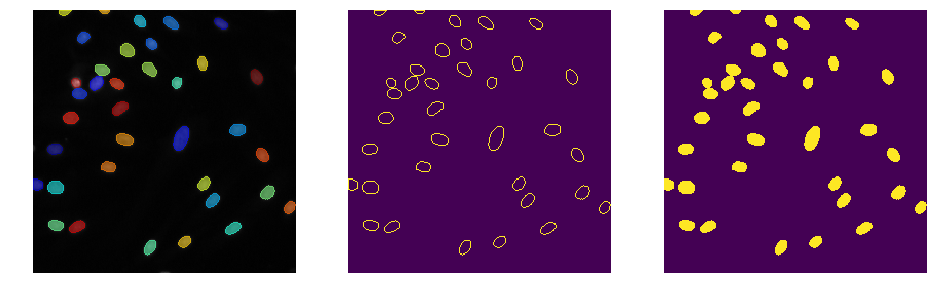

1 255 (256, 256, 3)


In [4]:
i=1
image, label = dataloader[ i ]
imagecell = view.makeimagecell(image, label, alphaback=0.5, alphaedge=0.5)
imageedge = view.makeedgecell(label)
imageback = view.makebackgroundcell(label)
maskedge = np.sum(imageedge,axis=2)>0
maskback = np.sum(imageback,axis=2)>0

#show
imageshowlist(imagecell, maskedge, maskback)
summary(image)


# Segementation

In [5]:
# configuration
PATHDATASET = '../db'
NAMEDATASET = 'databoewl'
PATHMODEL = 'netruns/exp_net_unet_dim388_lr0001_ep100_adam_b4_wk2_001'
#PATHMODEL = 'netruns/exp_net_unet_002/models'
NAMEMODEL = 'model_best.pth.tar'
RLNAME = 'test_masks.csv'
NUMITER = 5

In [6]:
# Setup Model

pathnamemodel = os.path.join(PATHMODEL, NAMEMODEL)
bcuda = torch.cuda.is_available()

if bcuda: model = torch.load( pathnamemodel )
else: model = torch.load( pathnamemodel, map_location=lambda storage, loc: storage )
num_classes = model['num_classes']

net = nnmodels.unet( n_classes = num_classes )
if bcuda: 
    net.cuda()

net.load_state_dict(model['state_dict'])
net.eval()

print('>> Model loader ready ...')


>> Model loader ready ...


In [7]:
def net_forward( net, image_in ):

    image_proc = image_in[:, :, :]
    image_proc = image_proc.astype(float)
    
    # NHWC -> NCHW
    image_proc = image_proc.transpose(2, 0, 1)
    image_proc = image_proc[np.newaxis,...]
    image_proc = torch.from_numpy(image_proc).float()

    if torch.cuda.is_available():
        net.cuda(0)
        images_torch = Variable(image_proc.cuda(0), volatile=True )
    else:
        images_torch = Variable(image_proc)

    # fordward
    outputs = net(images_torch)
    pred = tfun.softmax(outputs).data.cpu().numpy()        
    pred = pred.transpose(2,3,1,0)
    pred = pred[...,0]
    
    return pred


def net_tiled_forward( net, data, opts ):
    
    n_tiles = opts['n_tiles']
    padOutput = opts['padOutput']
    padInput  = opts['padInput']
    downsampleFactor = opts['downsampleFactor']
    padding = opts['padding']
    average_mirror = opts['average_mirror']
    
    imsize = np.array(data.shape[:2])
    d4a_size = np.ceil( (np.array([imsize[0], np.ceil( imsize[1]/n_tiles )]) - padOutput)/downsampleFactor  )    
    input_size = downsampleFactor*d4a_size + padInput;
    output_size = downsampleFactor*d4a_size + padOutput;        
    border = (np.round(input_size-output_size)//2);
    
    border = border.astype(int)
    input_size = input_size.astype(int)
    output_size = output_size.astype(int)
                         
    paddedFullImage = np.zeros( (data.shape[0] + 2*border[0], data.shape[1] + 2*border[1], data.shape[2] ) );
    paddedFullImage[ border[0]:border[0]+data.shape[0], border[1]:border[1]+data.shape[1], : ] = data;
       
    if padding == 'mirror':
        xpad  = border[0];
        xfrom = border[0]+1;
        xto   = border[0]+data.shape[0];        
        paddedFullImage[:xfrom,:,:] = paddedFullImage[ xfrom-1:xfrom+xpad,:,:][::-1,:,:];
        paddedFullImage[xto:,:,:] = paddedFullImage[xto-xpad:xto, :,:][::-1,:,:] ;
        ypad  = border[1];
        yfrom = border[1]+1;
        yto   = border[1]+ data.shape[1];        
        paddedFullImage[:, :yfrom,:] = paddedFullImage[ :, yfrom-1:yfrom+ypad,:][:,::-1,:];
        paddedFullImage[:, yto:,:] = paddedFullImage[ :, yto-ypad:yto, :][:,::-1,:];
        
            
    nClasses = 3
    scores = np.zeros( (data.shape[0],data.shape[1], nClasses) );
    for yi in range(n_tiles):
                
        paddedInputSlice = np.zeros( (input_size[0], input_size[1], data.shape[2]) )
        validReg_x = min( input_size[0], paddedFullImage.shape[0] )
        validReg_y = min( input_size[1], paddedFullImage.shape[1] - yi*output_size[1] )        
        paddedInputSlice[:validReg_x, :validReg_y] = paddedFullImage[:validReg_x, yi*output_size[1]:yi*output_size[1]+validReg_y,:]
        
        scoreSlice = net_forward( net, paddedInputSlice )      
        if average_mirror:            
            scores_torch = net_forward(net, np.fliplr(paddedInputSlice))
            scoreSlice   = np.fliplr(scores_torch)
            scores_torch = net_forward(net, np.fliplr(paddedInputSlice))
            scoreSlice   = np.fliplr(scores_torch)
            scores_torch = net_forward(net, np.flipud(paddedInputSlice))
            scoreSlice   = np.flipud(scores_torch)
            scores_torch = net_forward(net, np.flipud(np.fliplr(paddedInputSlice)) )
            scoreSlice   = np.flipud(np.fliplr(scores_torch))
            scoreSlice   = scoreSlice/4;
        
        print('>>')
        
        validReg_x = min(output_size[0], scores.shape[0] );
        validReg_y = min(output_size[1], scores.shape[1] - yi*output_size[1] );        
        scores[:validReg_x, yi*output_size[1]:yi*output_size[1]+validReg_y,:]= scoreSlice[:validReg_x,:validReg_y,:];
    
    return scores


def net_predition( net, image, ntiles=2, average_mirror=False ):    

    #preprosessing 
    image = normalize(image)    
    image = color.rgb2gray(image)
    image = image[:,:,np.newaxis]
    
    d4a_size = 0
    opts = {
        'n_tiles': ntiles,
        'padding': 'mirror',
        'downsampleFactor': 16,
        'padInput': (((d4a_size*2 +2 +2)*2 +2 +2)*2 +2 +2)*2 +2 +2,
        'padOutput': ((((d4a_size -2 -2)*2-2 -2)*2-2 -2)*2-2 -2)*2-2 -2,
        'average_mirror': average_mirror
        }

    pred = net_tiled_forward(net, image, opts )
    return pred



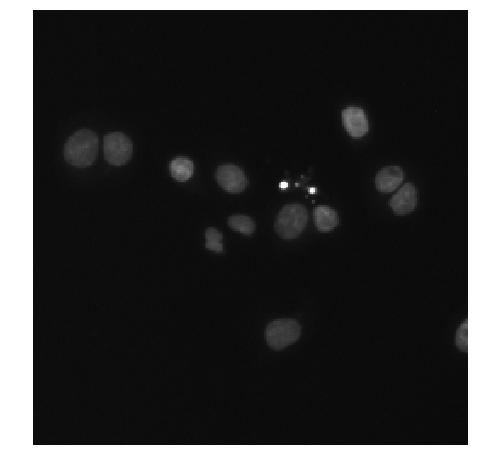

8 255 (256, 256, 3)


In [32]:
i=5
image, label = dataloader[ i ]
imageshow( image )
summary(image)


>>
>>
>>
(256, 256, 3)
DONE!!


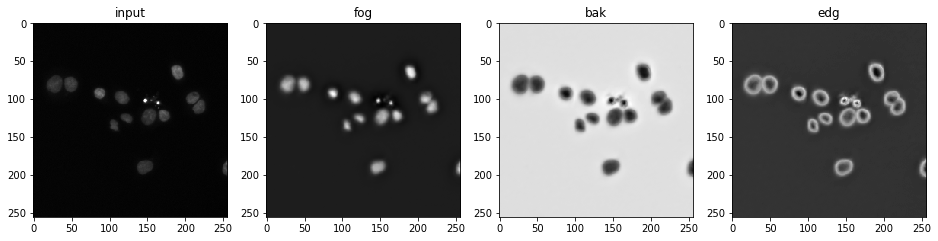

In [33]:
pred = net_predition(net,image, ntiles=3)
print(pred.shape)
print('DONE!!')

showsegmentation(pred) 

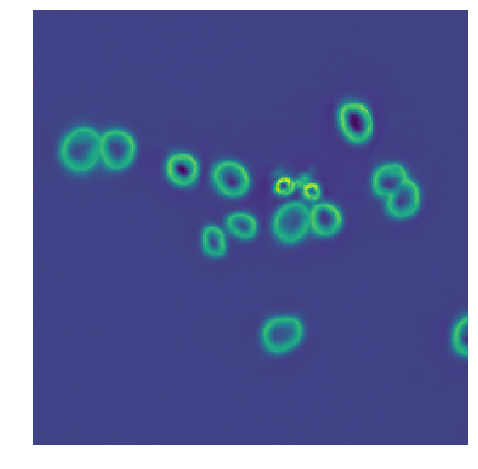

In [34]:
imageshow( normalize(pred[:,:,2]) )

dict_keys(['seg_data', 'prediction', 'line_data', 'fill_data'])
0 255 (256, 256, 4)


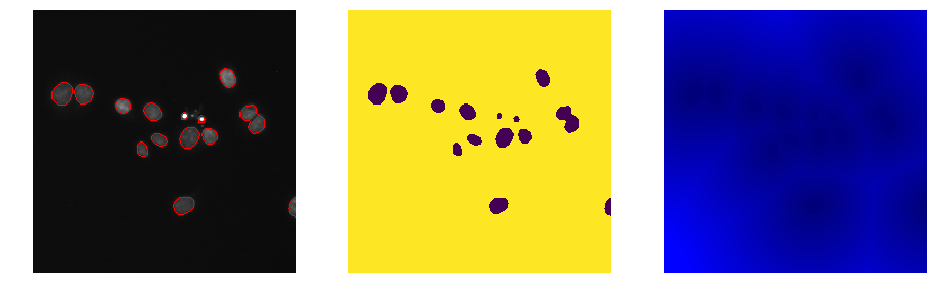

In [35]:
seginfo = nutl.process_data( pred[:,:,:2], line_width=1)
print(seginfo.keys())

imageinfo = seginfo['line_data']
summary(imageinfo)

mask_line = imageinfo[:,:,3]>0
image_sh = image.copy()
image_sh[mask_line,:] = [255,0,0];

imageshowlist(image_sh, seginfo['prediction'], seginfo['seg_data'][:,:,1:] )


# Pos procesecing

In [12]:
from itertools import product
import skimage.morphology as morph
from skimage.filters import threshold_otsu
import scipy.ndimage as ndi
from scipy.stats import itemfreq
from skimage.color import label2rgb

In [38]:
def pad_mask(mask, pad):
    if pad <= 1: pad = 2
    h, w = mask.shape
    h_pad = h + 2 * pad
    w_pad = w + 2 * pad
    mask_padded = np.zeros((h_pad, w_pad))
    mask_padded[pad:pad + h, pad:pad + w] = mask
    mask_padded[pad - 1, :] = 1
    mask_padded[pad + h + 1, :] = 1
    mask_padded[:, pad - 1] = 1
    mask_padded[:, pad + w + 1] = 1

    return mask_padded

def drop_artifacts_per_label(labels, initial_mask):
    labels_cleaned = np.zeros_like(labels)
    for i in range(1, labels.max() + 1):
        component = np.where(labels == i, 1, 0)
        component_initial_mask = np.where(labels == i, initial_mask, 0)
        component = drop_artifacts(component, component_initial_mask)
        labels_cleaned = labels_cleaned + component * i
    return labels_cleaned

def mean_blob_size(mask):
    
    labels, labels_nr = ndi.label(mask)
    if labels_nr < 2:
        mean_area = 1
        mean_radius = 1
    else:
        mean_area = int(itemfreq(labels)[1:, 1].mean())
        mean_radius = int(np.round(np.sqrt(mean_area) / np.pi))
    return mean_area, mean_radius

def crop_mask(mask, crop):
    if crop <= 1: crop = 2
    h, w = mask.shape
    mask_cropped = mask[crop:h - crop, crop:w - crop]
    return mask_cropped

def drop_artifacts(mask_after, mask_pre, min_coverage=0.5):
    connected, nr_connected = ndi.label(mask_after)
    mask = np.zeros_like(mask_after)
    for i in range(1, nr_connected + 1):
        conn_blob = np.where(connected == i, 1, 0)
        initial_space = np.where(connected == i, mask_pre, 0)
        blob_size = np.sum(conn_blob)
        initial_blob_size = np.sum(initial_space)
        coverage = float(initial_blob_size) / float(blob_size)
        if coverage > min_coverage:
            mask = mask + conn_blob
        else:
            mask = mask + initial_space
    return mask
    
def relabel(img):
    h, w = img.shape

    relabel_dict = {}

    for i, k in enumerate(np.unique(img)):
        if k == 0:
            relabel_dict[k] = 0
        else:
            relabel_dict[k] = i
    for i, j in product(range(h), range(w)):
        img[i, j] = relabel_dict[img[i, j]]
    return img

def drop_small(img, min_size):
    img = morph.remove_small_objects(img, min_size=min_size)
    return relabel(img)

def fill_holes_per_blob(image):
    image_cleaned = np.zeros_like(image)
    for i in range(1, image.max() + 1):
        mask = np.where(image == i, 1, 0)
        mask = ndi.morphology.binary_fill_holes(mask)
        image_cleaned = image_cleaned + mask * i
    return image_cleaned
    
def decompose(labeled):
    nr_true = labeled.max()
    masks = []
    for i in range(1, nr_true + 1):
        msk = labeled.copy()
        msk[msk != i] = 0.
        msk[msk == i] = 255.
        masks.append(msk)
    if not masks: return np.array([labeled])
    else: return np.array(masks)
    
def getlabel(mask):
    labeled, nr_true = ndi.label(mask)
    return labeled

def good_markers_v1(m_b,c_b):    
    mk_ = np.where(c_b,0,m_b)
    return mk_

def good_markers_v2(m_b,c_b):   
    mk_ = np.where(c_b,0,m_b)
    return mk_

def good_markers_v3(m_b,c_b):   
    mk_ = np.where(c_b,0,m_b)    
    area, radius = mean_blob_size(m_b)
    struct_size = int(0.25*radius)
    struct_el = morph.disk(struct_size)
    m_padded = pad_mask(mk_, pad=struct_size)
    m_padded = morph.erosion(m_padded, selem=struct_el)
    mk_ = crop_mask(m_padded, crop=struct_size)
    mk_,_ = ndi.label(mk_) 
    return mk_

def good_distance_v1(m_b):
    distance = ndi.distance_transform_edt(m_b)
    return distance

def add_dropped_water_blobs(water, mask_cleaned):
    water_mask = (water > 0).astype(np.uint8)
    dropped = mask_cleaned - water_mask
    dropped, _ = ndi.label(dropped)
    dropped = np.where(dropped, dropped + water.max(), 0)
    water = water + dropped
    return water

def watershed_v2(mask, contour):
    
    #cleaned_mask = clean_mask_v2(mask, contour)
    cleaned_mask = mask    
    good_markers = good_markers_v3(cleaned_mask,contour)
    good_distance = good_distance_v1(cleaned_mask)    
    water = morph.watershed(-good_distance, good_markers, mask=cleaned_mask)    
    water = add_dropped_water_blobs(water, cleaned_mask)    
    m_thresh = threshold_otsu(mask)
    initial_mask_binary = (mask > m_thresh).astype(np.uint8)    
    water = drop_artifacts_per_label(water,initial_mask_binary)    
    return water


def posprocessing( m, f, c ):
    
    #labels = getlabel(m)
    #labels = drop_artifacts_per_label(labels, m)
    #labels = drop_small(labels, min_size=20)
    #labels = fill_holes_per_blob(labels)
    
    labels = watershed_v2(m, c)    
    labels = np.transpose( decompose(labels), (1,2,0) )
    return labels



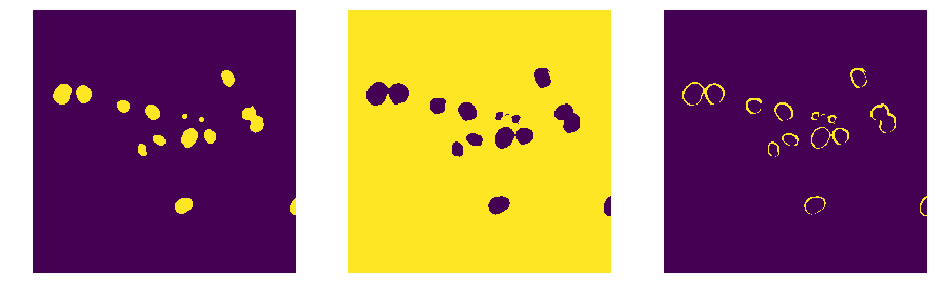

In [39]:
class_data = pred
class_data = np.argmax(class_data, axis=2).astype('uint8')
mask_bak = (class_data==0)
mask_fog = (class_data==1)
mask_edg = (class_data==2)

imageshowlist( mask_bak, mask_fog,  mask_edg )

0 255 (256, 256, 14)


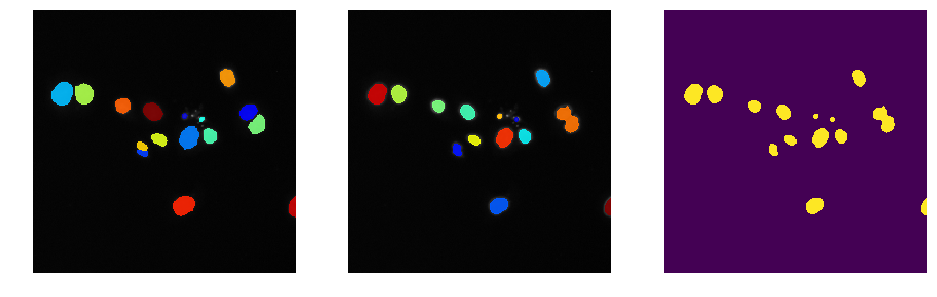

In [40]:

labels_est = posprocessing(mask_bak, mask_fog, mask_edg )
summary(labels_est)

imagecell = view.makeimagecell(image, label, alphaback=0.9, alphaedge=0.5)
imageedge = view.makeedgecell(label)
imageback = view.makebackgroundcell(label)
maskedge = np.sum(imageedge,axis=2)>0
maskback = np.sum(imageback,axis=2)>0

ch = labels_est.shape[2]
labels_est = labels_est[:,:, np.random.permutation(ch) ]
imagecell_est = view.makeimagecell(image, labels_est, alphaback=0.9, alphaedge=0.9)
imageshowlist(imagecell, imagecell_est, mask_bak )
    

# Encoder and Decoder

In [28]:
def rle_encode(img):
    '''
    img: numpy array, 1 - mask, 0 - background
    Returns run length as string formated
    '''
    pixels = img.flatten()
    pixels[0] = 0
    pixels[-1] = 0
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 2
    runs[1::2] = runs[1::2] - runs[:-1:2]
    return ' '.join(str(x) for x in runs)

def rle_decode(mask_rle, shape):
    '''
    mask_rle: run-length as string formated (start length)
    shape: (height,width) of array to return 
    Returns numpy array, 1 - mask, 0 - background

    '''
    s = mask_rle
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]   
    starts -= 1
    ends = starts + lengths
    img = np.zeros(shape[0]*shape[1], dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
    return img.reshape(shape)


In [41]:

rles = list()
for i in range( labels_est.shape[2] ):      
    idimage = dataloader.getid()
    rle = rle_encode(labels_est[:,:,i])    
    rles.append( {'ImageId':idimage, 'EncodedPixels':rle } )

submission = pd.DataFrame(rles).astype(str)
submission = submission[submission['EncodedPixels']!='nan']
submission_filepath = os.path.join(experiments_dir, 'submission.csv')
submission.to_csv(submission_filepath, index=None, encoding='utf-8')

print(submission.head())


                                       EncodedPixels  \
0                             27 9 283 9 539 9 798 3   
1  1895 2 2150 5 2405 7 2661 8 2917 8 3173 9 3431...   
2  2436 5 2691 7 2947 8 3203 9 3460 9 3716 9 3974...   
3   2741 3 2996 7 3252 7 3508 8 3765 8 4022 7 4280 4   
4  5936 5 6191 7 6447 8 6702 9 6958 8 7214 8 7471...   

                                             ImageId  
0  003cee89357d9fe13516167fd67b609a164651b2193458...  
1  003cee89357d9fe13516167fd67b609a164651b2193458...  
2  003cee89357d9fe13516167fd67b609a164651b2193458...  
3  003cee89357d9fe13516167fd67b609a164651b2193458...  
4  003cee89357d9fe13516167fd67b609a164651b2193458...  


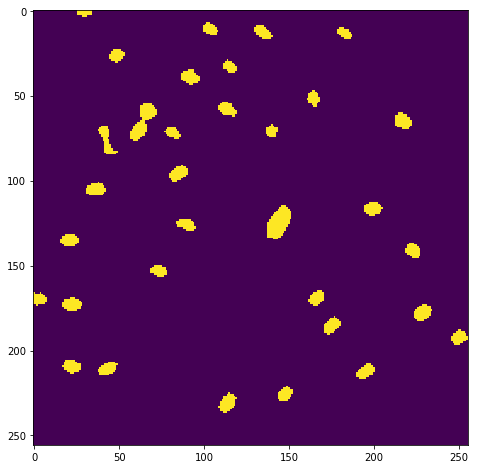

In [44]:

h,w = image.shape[:2]
#rle = dataloader.getrl()

rlelabel = np.zeros( (h,w) )
for i in range( len(rles) ):
    rlelabel += rle_decode(rles[i]['EncodedPixels'].split(),(h,w))

plt.figure( figsize=(8,8))
plt.imshow( rlelabel )
plt.show()